In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#Function to read data from file
def get_data(din):
    bf = pd.read_csv(din,sep='\t')
    genes = bf['Hugo_Symbol']
    cols = list(bf.columns)
    cols.remove('Entrez_Gene_Id')
    cols.remove('Hugo_Symbol')
    bf = bf[cols]
    bf = bf.transpose()
    bf.columns = genes
    return bf

def getDataset(din1, din2, din3):
    normal1 = get_data(din1)
    normal2 = get_data(din2)
    abnormal = get_data(din3)
    common_gene = set(list(normal1.columns)).intersection(set(list(normal2.columns))).intersection(set(list(abnormal.columns)))
    common_gene = list(common_gene)
    normal1 = normal1[common_gene]
    normal2 = normal2[common_gene]
    abnormal = abnormal[common_gene]
    #abnormal = list(abnormal)
    
    X_train = pd.concat( [normal1, normal2] ).values
    
    abnormal = abnormal.values.tolist()
    normal1 = normal1.values.tolist()
    
    abnormal = list(np.float_(abnormal))
    normal1 = list(np.float_(normal1))
    
    abnormal = rd.SystemRandom().sample(abnormal, 25)
    normal1 = rd.SystemRandom().sample(normal1, 60)
    
    abnormal = pd.DataFrame(abnormal)
    normal1 = pd.DataFrame(normal1)
    
    #X_train = np.random.shuffle(X_train) 
    X_test = pd.concat( [normal1, abnormal] ).values
    y_test = np.zeros(len(X_test), dtype=int)
    y_test[len(normal1):] = 1
    

    
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)
                

    return X_train, X_test, y_test

In [3]:
# Code to visualize the results

class Visualization:
    labels = ["Normal","Anomal"]
    
    def draw_confusion_matrix(self, y, y_pred):
        matrix = confusion_matrix(y, y_pred)
        
        plt.figure(figsize=(10,8))
        colors = ["orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.show()
        
    def draw_anomaly(self, y, error, treshold):
        groupsDF = pd.DataFrame({'error':error,'true':y}).groupby('true')
        
        figure,axes = plt.subplots(figsize=(12,8))
        
        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                     color='r' if name ==1 else 'g', label="Anomaly" if name == 1 else "Normal")
            
        axes.hlines(treshold, axes.get_xlim()[0], axes.get_xlim()[1], colors='b', zorder = 100, label = 'Treshold')
        axes.legend()
            
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
        
    def draw_error(self, error, treshold):
        plt.plot(error, marker='o', ms=3.5, linestyle='', label='Point')
        
        plt.hlines(treshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Treshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
    

In [4]:
din1 = 'data/breast-rsem-fpkm-gtex.txt'
din2 = 'data/brca-rsem-fpkm-tcga.txt'
din3 = 'data/brca-rsem-fpkm-tcga-t.txt'

X_train, X_test, y_test = getDataset(din1, din2, din3)


In [6]:
from numpy import savetxt

savetxt('dataset/x_train_brc.csv', X_train, delimiter='\t')
savetxt('dataset/x_test_brc.csv', X_test, delimiter='\t')
savetxt('dataset/y_test_brc.csv', y_test, delimiter='\t')



In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [8]:
print(X_test)

[[0.11475427 0.17182512 0.49796985 ... 0.33107336 0.38184438 0.00386266]
 [0.1618725  0.52205488 0.38676089 ... 0.10325209 0.27628818 0.00311159]
 [0.43228665 0.09971679 0.15084448 ... 0.20664822 0.19311816 0.01979614]
 ...
 [0.51976935 0.01168483 0.03341852 ... 0.08357082 0.26379251 0.01813305]
 [0.3273538  0.12985727 0.10130963 ... 0.16041317 0.30906052 0.01893777]
 [0.08306569 0.27340623 0.31071799 ... 0.36053869 0.28911816 0.03551502]]


In [9]:
X_train.shape

(199, 19738)

In [10]:
X_test.shape

(85, 19738)

In [11]:
print(y_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]


In [12]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [13]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [14]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [15]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# sampling 
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var]) 

# instantiate encoder model
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 19738)]      0           []                               
                                                                                                  
 dense (Dense)                  (None, 9869)         194804191   ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 6579)         64934730    ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 6579)         64934730    ['dense[0][0]']                  
                                                                                            

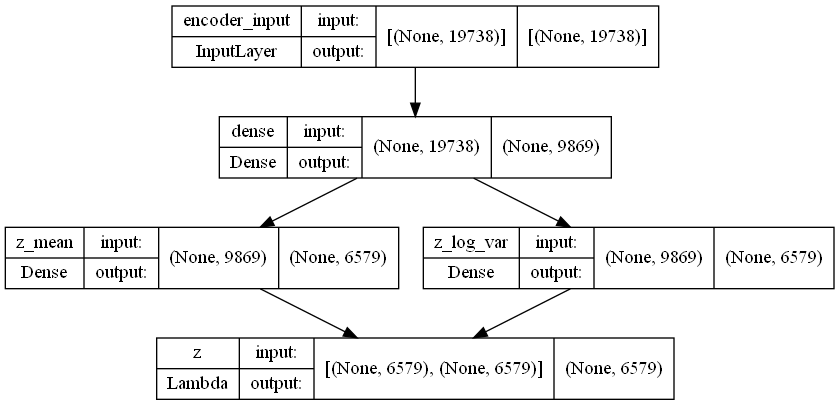

In [16]:
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

In [17]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 6579)]            0         
                                                                 
 dense_1 (Dense)             (None, 9869)              64938020  
                                                                 
 dense_2 (Dense)             (None, 19738)             194814060 
                                                                 
Total params: 259,752,080
Trainable params: 259,752,080
Non-trainable params: 0
_________________________________________________________________


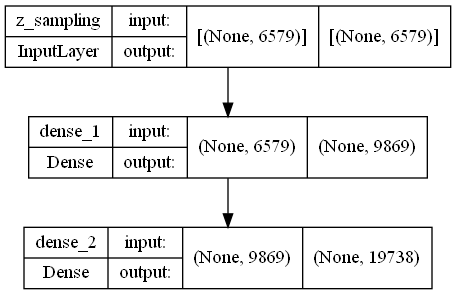

In [18]:
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

In [19]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

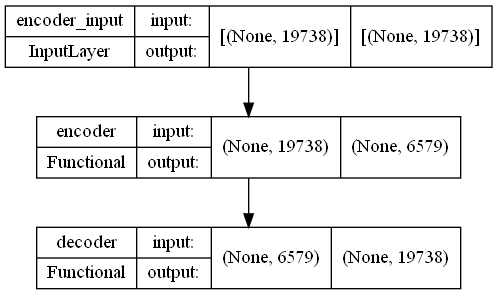

In [20]:
plot_model(vae_model, to_file='vae_mlp_model.png', show_shapes=True)

In [21]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [22]:
#opt = optimizers.Adam(learning_rate=0.01)


epochs = 200
learning_rate = 0.0001
decay_rate = learning_rate / epochs
#opt = optimizers.RMSprop(learning_rate=learning_rate, decay=decay_rate)
opt = optimizers.Adam(learning_rate=learning_rate, decay=decay_rate)
vae_model.compile(optimizer=opt, loss=vae_loss)

#vae_model.compile(optimizer='adam',
#                  loss=vae_loss)

vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 19738)]           0         
                                                                 
 encoder (Functional)        (None, 6579)              324673651 
                                                                 
 decoder (Functional)        (None, 19738)             259752080 
                                                                 
Total params: 584,425,731
Trainable params: 584,425,731
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Learning
# Finally, we train the model:
history = vae_model.fit(X_train, X_train, 
                        shuffle=True, 
                        epochs=epochs, 
                        batch_size=256, 
                        validation_data=(X_test, X_test))
#history = vae_model.fit(X_train, X_train,
#                        shuffle=True,
#                        epochs=10,
#                        batch_size=256)

vae_model.save_weights('vae_breast.h5')

Train on 199 samples, validate on 85 samples
Epoch 1/200
199/199 [==============================] - ETA: 0s - loss: 544109.3750

C:\Users\Innocent SADO\Anaconda3\envs\Master2\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


199/199 [==============================] - 105s 525ms/sample - loss: 544109.3750 - val_loss: 165624.9219
Epoch 2/200
199/199 [==============================] - 55s 276ms/sample - loss: 354780.5000 - val_loss: 106925.2969
Epoch 3/200
199/199 [==============================] - 57s 288ms/sample - loss: 202069.3281 - val_loss: 112885.9375
Epoch 4/200
199/199 [==============================] - 40s 202ms/sample - loss: 194098.4062 - val_loss: 101683.2031
Epoch 5/200
199/199 [==============================] - 39s 198ms/sample - loss: 161049.0000 - val_loss: 84365.8906
Epoch 6/200
199/199 [==============================] - 36s 183ms/sample - loss: 121613.4297 - val_loss: 79105.1562
Epoch 7/200
199/199 [==============================] - 38s 193ms/sample - loss: 117711.0859 - val_loss: 78204.1797
Epoch 8/200
199/199 [==============================] - 39s 198ms/sample - loss: 120001.9531 - val_loss: 74641.3047
Epoch 9/200
199/199 [==============================] - 36s 182ms/sample - loss: 111403.

199/199 [==============================] - 40s 201ms/sample - loss: 56734.4922 - val_loss: 55092.5352
Epoch 73/200
199/199 [==============================] - 43s 214ms/sample - loss: 56338.2695 - val_loss: 55066.5820
Epoch 74/200
199/199 [==============================] - 51s 257ms/sample - loss: 55952.4805 - val_loss: 54943.6484
Epoch 75/200
199/199 [==============================] - 39s 198ms/sample - loss: 55604.3711 - val_loss: 54707.6523
Epoch 76/200
199/199 [==============================] - 48s 240ms/sample - loss: 55275.8711 - val_loss: 54700.7070
Epoch 77/200
199/199 [==============================] - 44s 222ms/sample - loss: 54926.5469 - val_loss: 54498.3242
Epoch 78/200
199/199 [==============================] - 48s 241ms/sample - loss: 54565.0391 - val_loss: 54269.0352
Epoch 79/200
199/199 [==============================] - 47s 238ms/sample - loss: 54253.1016 - val_loss: 54158.4297
Epoch 80/200
199/199 [==============================] - 49s 244ms/sample - loss: 53959.1172 -

Epoch 143/200
199/199 [==============================] - 41s 204ms/sample - loss: 38941.1250 - val_loss: 46824.9688
Epoch 144/200
199/199 [==============================] - 46s 230ms/sample - loss: 38706.5781 - val_loss: 46967.2461
Epoch 145/200
199/199 [==============================] - 38s 193ms/sample - loss: 38491.5938 - val_loss: 46767.2617
Epoch 146/200
199/199 [==============================] - 39s 197ms/sample - loss: 38324.2852 - val_loss: 46809.3320
Epoch 147/200
199/199 [==============================] - 40s 202ms/sample - loss: 38137.5430 - val_loss: 46636.3789
Epoch 148/200
199/199 [==============================] - 38s 191ms/sample - loss: 37909.8789 - val_loss: 46552.1367
Epoch 149/200
199/199 [==============================] - 43s 218ms/sample - loss: 37742.3750 - val_loss: 46619.7266
Epoch 150/200
199/199 [==============================] - 40s 199ms/sample - loss: 37515.0234 - val_loss: 46560.5508
Epoch 151/200
199/199 [==============================] - 47s 238ms/sampl

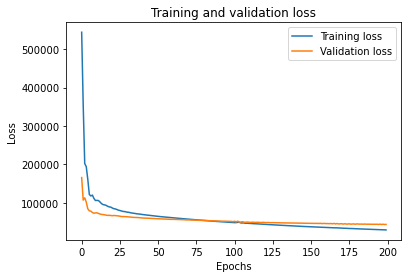

In [24]:
# plot loss history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend(['Training loss', 'Validation loss'], loc='upper right');
plt.show()


In [25]:
score = vae_model.evaluate(X_test, X_test, verbose = 1)

In [26]:
print('Test Loss:', score)

Test Loss: 15659.709673713236


In [27]:
#mae_vector = get_error_term(X_pred, X_test)#, _rmse=False)

# Code to predict the anomalies based on the threshold


y_pred = vae_model.predict(X_test)
y_dist = np.linalg.norm(X_test - y_pred, axis = -1)
threshold = np.quantile(y_dist, 0.75)
#threshold = 37.5

z = zip(y_dist >= threshold, y_dist)
y_label=[]
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

C:\Users\Innocent SADO\Anaconda3\envs\Master2\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [28]:
threshold

24.115543840995745

In [29]:
#Code to calculate AUC
from sklearn.metrics import confusion_matrix, roc_auc_score

roc_auc_score(y_test, y_label)

0.94

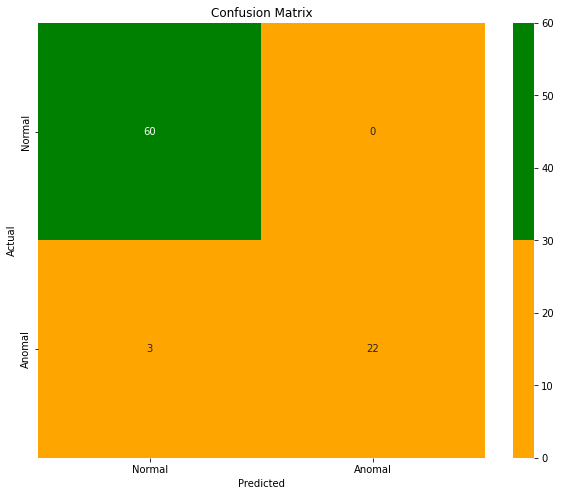

In [30]:
# Code to show the confusion matrix

viz = Visualization()
viz.draw_confusion_matrix(y_test, y_label)

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       1.00      0.88      0.94        25

    accuracy                           0.96        85
   macro avg       0.98      0.94      0.96        85
weighted avg       0.97      0.96      0.96        85



In [32]:
from sklearn import metrics

#y_pred =  (mae_vector > error_thresh).astype('int').ravel()
y_pred =  y_label
AUC = metrics.roc_auc_score(y_test, y_pred)
F1 = metrics.f1_score(y_test, y_pred)
Accuracy = metrics.accuracy_score(y_test, y_pred)
Precision = metrics.precision_score(y_test, y_pred)
Recall = metrics.recall_score(y_test, y_pred)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
Specificity = tn / (tn+fp)

print("AUC: {:.2%}\n".format(AUC))
print("F1_score: {:.2%}\n".format(F1))
print("Accuracy: {:.2%}\n".format(Accuracy))
print("Precision: {:.2%}\n".format(Precision))
print("Recall: {:.2%}\n".format(Recall))
print("Specificity: {:.2%}\n".format(Specificity))

AUC: 94.00%

F1_score: 93.62%

Accuracy: 96.47%

Precision: 100.00%

Recall: 88.00%

Specificity: 100.00%

